# Classical ML on OCD classification

## Import Required Modules

In [1]:
%load_ext autoreload
%autoreload 2

## Import System tools

In [2]:
import os
import sys
import gc
import cProfile
import warnings

In [3]:
current_dir = os.getcwd()
helpers = os.path.join(current_dir, "helpers")
sys.path.insert(0,helpers)

## Importing libraries

In [4]:
from enum import Enum, IntEnum
import itertools
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.markers as markers
import seaborn as sns
import json
import pickle
from tabulate import tabulate
from logger import logger
import directory_manager as dm
import object_manager as om
import data_structures as ds
import df_manager as dfm
from data_model import Metrics, CSVHeader,HandWashingType
import plotter
import sampler

2023-08-21 23:25:58 - INFO - Logger Created.


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, PassiveAggressiveClassifier, Perceptron
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, matthews_corrcoef,average_precision_score
from imblearn.over_sampling import RandomOverSampler, SMOTE, KMeansSMOTE, SVMSMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks, EditedNearestNeighbours, ClusterCentroids
from imblearn.combine import SMOTETomek, SMOTEENN

## Setup

In [6]:
warnings.filterwarnings("ignore")

In [7]:
dm.generate_name("")

'2023-08-21_23-25-59'

In [8]:
logger.info("Running Notebook.")

2023-08-21 23:25:59 - INFO - Running Notebook.


## Global Variables

In [9]:
WINDOW_TIME = 3 # Seconds
FREQUENCY = 50 # 50Hz
WINDOW_SIZE = WINDOW_TIME*FREQUENCY
DIR = "/data/OCDetect_Export"
DROP_STATS = ["count"] # Stats to drop
IGNORE_LIST = [val for val in range(1,7)] # Ignore types
LABELS = ['Others','Routine HW', 'Compulsive HW']

### Data

In [10]:
data_folder = "OCDetect_Export"
csv_files = dm.get_files_names(dm.get_data_dir(data_folder))
grouped_csv_files = ds.group_by_subjects(csv_files)

### Feature to Select

In [11]:
features_sel = ['acc z_min', 'acc z_std', 'gyro x_25%', 'gyro x_75%', 
            'gyro x_max', 'gyro x_min', 'gyro x_std', 'gyro y_max', 
            'acc y_min', 'acc y_25%', 'acc y_mean', 'acc z_25%', 
            'gyro z_max', 'acc z_max', 'acc y_max']
features_sensor = ['acc x', 'acc y', 'acc z', 'gyro x', 'gyro y', 'gyro z']
features_acc = ['acc x', 'acc y', 'acc z']
features_gyro = ['gyro x', 'gyro y', 'gyro z']

# Features to be selected
features = features_sensor

### Assign Subjects for training and inference

In [12]:
# Subjects
#subjects = ['02', '05', '25', '30', '20', '19', '04', '21', '03', '12', '01', '11', '29', '10', '09', '18', '13']
subjects = ['02', '19', '12', '09','10']
subjects = sorted(subjects)

# Inference
inferences = ['07','22'] #['07', '27', '15', '24', '22']
inferences = sorted(inferences)

### Select classifier and normalization method

In [13]:
classifier = 'Perceptron'#'PassiveAggressiveClassifier'#"MultinomialNB" #"SGDClassifier"
norm_method = 'standard'

## Classical ML

**Supported classifiers:**
- logistic_regression
- random_forest 
- gradient_boosting
- svm 
- kmeans
- neuralnetwork
- SGDClassifier
- MultinominalNB
- PassiveAggressiveClassifier
- Perceptron

In [14]:
def get_model(name, **kwargs):
    if name == 'logistic_regression':
        model = LogisticRegression(**kwargs)
    elif name == 'random_forest':
        model = RandomForestClassifier(**kwargs)
    elif name == 'gradient_boosting':
        model = GradientBoostingClassifier(**kwargs)
    elif name == 'svm':
        model = SVC(**kwargs)
    elif name == 'kmeans':
        model = KMeans(n_clusters=3, **kwargs)
    elif name == 'neuralnetwork':
        model = MLPClassifier(**kwargs)
    elif name == 'SGDClassifier':
        model = SGDClassifier(**kwargs)
    elif name == 'MultinomialNB':
        model = MultinomialNB()
    elif name == 'PassiveAggressiveClassifier':
        model = PassiveAggressiveClassifier()
    elif name ==  'Perceptron':
        model = Perceptron()
    else:
        error = "Invalid classifier choice.\
        Supported classifiers: logistic_regression, random_forest, \
        gradient_boosting, svm, kmeans, neuralnetwork, MultinomialNB, PassiveAggressiveClassifier."
        logger.critical(error)
        raise ValueError(error)
    
    logger.info(f"ML model {name} initialized.")
    return model

### Evaluation functions

In [15]:
# Evaluates model for given csv filesdata_folder,True, norm_method, features
def evalute_model_for(model, filenames:list, data_folder:str, normalize=True, norm_method='standard', features=[]):
    # Dictionary to store results of all csv files
    metrics = {
    key: []
    for key in [
        Metrics.Accuracy.value,
        Metrics.Precision.value,
        Metrics.Recall.value,
        Metrics.F1.value,
        Metrics.Sample.value,
        #Metrics.ROC.value,
        #Metrics.ROC_PR.value, #Not supported multi-class
        #Metrics.MCC.value
    ]
    }

    # Dictionary to store weighted avergae metrics
    weighted_avg_metrics = {}
    
    #Loop over csv files of each subject
    for file in filenames:
        #Load data
        x_test, y_test = dfm.load_data(file, data_folder, normalize, norm_method,features, sampling=False)
        # Evaluate the classifier on the current chunk
        y_pred = model.predict(x_test)
        
        # Get evaluation metrics
        result = evaluate_metrics(y_test,y_pred)
        
        # Concat values
        metrics.update(result)
    
    
    # Calculate total number of samples
    total_samples = sum(metrics[Metrics.Sample.value])
    
    # Calculate the weighted average metrics
    
    for key, values in metrics.items():
        if key != Metrics.Sample.value:
            weighted_key_sum =  sum(val * count for val, count in zip(values, metrics[Metrics.Sample.value]))
            weighted_avg_metrics[key]= weighted_key_sum / total_samples
            
    return weighted_avg_metrics

# Function to evaluate metrics on given test, pred
def evaluate_metrics(y_test, y_pred, average='macro'):
    #Default Weighted Averaging for imbalanced dataset
    
    # Dict to store metrics
    metrics = {}
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average=average)
    recall = recall_score(y_test, y_pred, average=average)
    f1 = f1_score(y_test, y_pred, average=average)
    sample = len(y_test)
    #roc_auc = roc_auc_score(y_test, y_pred)
    #pr_auc = average_precision_score(y_test, y_pred, average=average)
    ##mcc = matthews_corrcoef(y_test, y_pred)
    
    # Store to dict as array
    metrics[Metrics.Accuracy.value] = [accuracy]
    metrics[Metrics.Precision.value] = [precision]
    metrics[Metrics.Recall.value] = [recall]
    metrics[Metrics.F1.value] = [f1]
    metrics[Metrics.Sample.value] = [sample]
    #metrics[Metrics.ROC.value] = [roc_auc]
    #metrics[Metrics.ROC_PR.value] = [pr_auc]
    #metrics[Metrics.MCC.value] = [mcc]
    
    return metrics

### Training Function

In [16]:
# Perform training of classifier
def train_model(classifier:str, subjects:list, data_folder:str, **kwargs):
    
    #start time
    startTime = datetime.now()
    logger.info(f"Training has started at {startTime}")

    
    if not subjects:
        logger.critical("Subjects cannot be empty.")
        raise ValueError("Subjects cannot be empty.")
    
    logger.info("==="*20)    
    logger.info("Training Phase Initialized.")
    logger.info(f"ML Algorithm:{classifier}")
    logger.info(f"Data Folder:{data_folder}")
    
    # Empty list to store results of each iterations
    results = []
    
    # Empty list to store selected features
    features  = []
    
    # Get features to consider otherwise emtpy
    if 'features' in kwargs:        
        features = kwargs['features']
        logger.info(f"Selected features as : {features}")
    
    if 'normalize' in kwargs:
        normalize = kwargs['normalize']
        logger.info(f"Normalization : {normalize}")
    
    # Default normalization method
    norm_method = 'standard'

    # Get normalization method 
    if 'norm_method' in kwargs:
        norm_method = kwargs['norm_method']
    
    logger.info(f"Selected Normalization method : {norm_method}")
                
    # folder to save models
    folder = dm.generate_name()
    logger.info(f"Models folder:{folder}")
    logger.info("==="*20)

    total_subjects = len(subjects)
    
    logger.info(f"Performing LOSO-CV on {total_subjects}.")
    # Perform LOSO-CV
    for index, test_subject in enumerate(subjects):
        logger.info("==="*20)
        logger.info(f"{index+1}/{total_subjects}. Leaving Subject {test_subject}:")
        # Initialize the selected classifier
        model = get_model(classifier)
        
        # Phase I: Training Phase
        
        # Get training subjects
        train_subjects = subjects.copy()
        train_subjects.remove(test_subject)
        logger.info("***"*20)
        logger.info("Phase I. Training:")
        # Loop over train subjects
        for idx, train_subject in enumerate(train_subjects):
            logger.info(f"{idx+1}/{total_subjects - 1}. Training on subject {train_subject}")
            
            #x_temp, y_temp = pd.DataFrame([]), pd.DataFrame([])
            subject_files = grouped_csv_files[train_subject]
            #Loop over csv files of each subject
            for index, train_file in enumerate(subject_files):
                logger.info(f"{index+1}/{len(subject_files)}. Working in file {train_file}.")
                #Load training data
                x_train, y_train = dfm.load_data(train_file, data_folder, normalize, norm_method,features)
                
                if len(x_train)>0:
                    # Train the classifier on the current csv file
                    model.partial_fit(x_train, y_train, classes=[0., 1., 2.])
                else:
                    logger.warning(f"Skipping training {train_file}. The file has not important data.")
            logger.info(f"Training complete on subjects:{train_subject}.")
        logger.info("***"*20)
        logger.info(f"Phase II: Testing subject:{test_subject}")
        
        # Phase II: Testing Phase
        weighted_avg_metrics = evalute_model_for(model, grouped_csv_files[test_subject],data_folder,normalize, norm_method, features)
        logger.info("***"*20)
        logger.info(f"{index}/{total_subjects}. Results:")
        for k, v in weighted_avg_metrics.items():
            logger.info(f"{k}:{v:.2f}")

        # Append metrics to result of one complete phase
        results.append({test_subject:weighted_avg_metrics})
        
        # Save model
        msg = om.save_object(model,f"models/{folder}", f"{test_subject}.pt")
        logger.info(msg)
        logger.info("***"*20)
    
    # Save whole result
    msg = om.save_object(results,f"models/{folder}", "results.pt")
    logger.info(msg)
    logger.info("==="*20)
    logger.info("Complete")
    # EndTime
    endTime = datetime.now()
    logger.info(f"Total time elapsed for training : {endTime - startTime}")
    
    return folder, results

In [17]:
folder, results = train_model(classifier, subjects, data_folder, 
                      features=features, normalize=True, norm_method=norm_method, 
                      random_state =25, n_estimators=200, max_depth=10)

2023-08-21 23:25:59 - INFO - ============================================================
2023-08-21 23:25:59 - INFO - Training Phase Initialized.
2023-08-21 23:25:59 - INFO - ML Algorithm:Perceptron
2023-08-21 23:25:59 - INFO - Data Folder:OCDetect_Export
2023-08-21 23:25:59 - INFO - Selected features as : ['acc x', 'acc y', 'acc z', 'gyro x', 'gyro y', 'gyro z']
2023-08-21 23:25:59 - INFO - Normalization : True
2023-08-21 23:25:59 - INFO - Selected Normalization method : standard
2023-08-21 23:25:59 - INFO - Models folder:2023-08-21_23-25-59
2023-08-21 23:25:59 - INFO - ============================================================
2023-08-21 23:25:59 - INFO - Performing LOSO-CV on 5.
2023-08-21 23:25:59 - INFO - ============================================================
2023-08-21 23:25:59 - INFO - 1/5. Leaving Subject 02:
2023-08-21 23:25:59 - INFO - ML model Perceptron initialized.
2023-08-21 23:25:59 - INFO - ************************************************************
2023-08-21

2023-08-21 23:26:43 - INFO - Original distribution: Counter({0: 684730, 1: 3512, 2: 288})
2023-08-21 23:26:43 - INFO - Class distribution after oversampling: Counter({0: 684730, 1: 4390, 2: 4390})
2023-08-21 23:26:43 - INFO - Class distribution after RandomUnderSampler: Counter({0: 228243, 1: 4390, 2: 4390})
2023-08-21 23:26:44 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4390, 1: 4390, 2: 4390})
2023-08-21 23:26:44 - INFO - ---------------
2023-08-21 23:26:44 - INFO - 17/31. Working in file OCDetect_09_recording_16_2e337801-de3e-43cc-95c4-e8dcaa3ee612.csv.
2023-08-21 23:26:44 - INFO - Loading CSV File: OCDetect_09_recording_16_2e337801-de3e-43cc-95c4-e8dcaa3ee612.csv from OCDetect_Export.
2023-08-21 23:26:48 - INFO - Original distribution: Counter({0: 1344809, 1: 6990})
2023-08-21 23:26:48 - INFO - Class distribution after oversampling: Counter({0: 1344809, 1: 22717})
2023-08-21 23:26:48 - INFO - Class distribution after RandomUnderSampler: Counter({0: 448269,

2023-08-21 23:27:37 - INFO - 2/4. Training on subject 10
2023-08-21 23:27:37 - INFO - 1/30. Working in file OCDetect_10_recording_00_5e56a5d9-fedb-4ff8-9ef1-464d40b28963.csv.
2023-08-21 23:27:37 - INFO - Loading CSV File: OCDetect_10_recording_00_5e56a5d9-fedb-4ff8-9ef1-464d40b28963.csv from OCDetect_Export.
2023-08-21 23:27:37 - INFO - ---------------
2023-08-21 23:27:37 - INFO - 2/30. Working in file OCDetect_10_recording_01_38b5a768-9bf4-42f3-8076-d31ec103364c.csv.
2023-08-21 23:27:37 - INFO - Loading CSV File: OCDetect_10_recording_01_38b5a768-9bf4-42f3-8076-d31ec103364c.csv from OCDetect_Export.
2023-08-21 23:27:38 - INFO - ---------------
2023-08-21 23:27:38 - INFO - 3/30. Working in file OCDetect_10_recording_02_8cd850ee-a083-421c-964c-92cc15be2130.csv.
2023-08-21 23:27:38 - INFO - Loading CSV File: OCDetect_10_recording_02_8cd850ee-a083-421c-964c-92cc15be2130.csv from OCDetect_Export.
2023-08-21 23:27:39 - INFO - ---------------
2023-08-21 23:27:39 - INFO - 4/30. Working in fil

2023-08-21 23:28:05 - INFO - Original distribution: Counter({0: 906818, 1: 1901})
2023-08-21 23:28:05 - INFO - Class distribution after oversampling: Counter({0: 906818, 1: 6178})
2023-08-21 23:28:06 - INFO - Class distribution after RandomUnderSampler: Counter({0: 302272, 1: 6178})
2023-08-21 23:28:06 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 6178, 1: 6178})
2023-08-21 23:28:06 - INFO - ---------------
2023-08-21 23:28:06 - INFO - 26/30. Working in file OCDetect_10_recording_25_ef84a15c-bb3a-459a-aca9-a606edfed9d6.csv.
2023-08-21 23:28:06 - INFO - Loading CSV File: OCDetect_10_recording_25_ef84a15c-bb3a-459a-aca9-a606edfed9d6.csv from OCDetect_Export.
2023-08-21 23:28:07 - INFO - ---------------
2023-08-21 23:28:07 - INFO - 27/30. Working in file OCDetect_10_recording_26_78be23c0-2c49-4217-a7c0-ca39ed26c2e6.csv.
2023-08-21 23:28:07 - INFO - Loading CSV File: OCDetect_10_recording_26_78be23c0-2c49-4217-a7c0-ca39ed26c2e6.csv from OCDetect_Export.
2023-08-21 2

2023-08-21 23:28:25 - INFO - Loading CSV File: OCDetect_12_recording_08_956dd080-20f2-4ef0-893c-f81e16f15d57.csv from OCDetect_Export.
2023-08-21 23:28:26 - INFO - Original distribution: Counter({0: 54514, 2: 3802})
2023-08-21 23:28:26 - INFO - Class distribution after oversampling: Counter({0: 54514, 2: 12356})
2023-08-21 23:28:26 - INFO - Class distribution after RandomUnderSampler: Counter({0: 18171, 2: 12356})
2023-08-21 23:28:26 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 12356, 0: 5303})
2023-08-21 23:28:26 - INFO - ---------------
2023-08-21 23:28:26 - INFO - 10/18. Working in file OCDetect_12_recording_09_aff54046-be1e-4fa8-aa74-09185049f085.csv.
2023-08-21 23:28:26 - INFO - Loading CSV File: OCDetect_12_recording_09_aff54046-be1e-4fa8-aa74-09185049f085.csv from OCDetect_Export.
2023-08-21 23:28:27 - INFO - Original distribution: Counter({0: 78409, 2: 1901})
2023-08-21 23:28:27 - INFO - Class distribution after oversampling: Counter({0: 78409, 2: 6178}

2023-08-21 23:28:56 - INFO - Original distribution: Counter({0: 1594494, 1: 11406, 2: 9505})
2023-08-21 23:28:57 - INFO - Class distribution after oversampling: Counter({0: 1594494, 2: 14257, 1: 14257})
2023-08-21 23:28:57 - INFO - Class distribution after RandomUnderSampler: Counter({0: 531498, 1: 14257, 2: 14257})
2023-08-21 23:28:59 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 14257, 1: 14257, 2: 14257})
2023-08-21 23:28:59 - INFO - ---------------
2023-08-21 23:28:59 - INFO - 5/34. Working in file OCDetect_19_recording_04_3742c49b-0856-494c-a474-17b63f842760.csv.
2023-08-21 23:28:59 - INFO - Loading CSV File: OCDetect_19_recording_04_3742c49b-0856-494c-a474-17b63f842760.csv from OCDetect_Export.
2023-08-21 23:29:03 - INFO - Original distribution: Counter({0: 1512121, 1: 20541, 2: 5873})
2023-08-21 23:29:03 - INFO - Class distribution after oversampling: Counter({0: 1512121, 2: 25676, 1: 25676})
2023-08-21 23:29:04 - INFO - Class distribution after RandomUnd

2023-08-21 23:30:27 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 33332, 0: 30290})
2023-08-21 23:30:27 - INFO - ---------------
2023-08-21 23:30:27 - INFO - 19/34. Working in file OCDetect_19_recording_18_af3992cb-f4a6-4e8d-adbd-af7949c04552.csv.
2023-08-21 23:30:27 - INFO - Loading CSV File: OCDetect_19_recording_18_af3992cb-f4a6-4e8d-adbd-af7949c04552.csv from OCDetect_Export.
2023-08-21 23:30:30 - INFO - Original distribution: Counter({0: 2153449, 1: 1901})
2023-08-21 23:30:30 - INFO - Class distribution after oversampling: Counter({0: 2153449, 1: 6178})
2023-08-21 23:30:31 - INFO - Class distribution after RandomUnderSampler: Counter({0: 717816, 1: 6178})
2023-08-21 23:30:32 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 6178, 1: 6178})
2023-08-21 23:30:32 - INFO - ---------------
2023-08-21 23:30:32 - INFO - 20/34. Working in file OCDetect_19_recording_19_668e9c21-b11b-41c7-98d8-9648fac5f9b9.csv.
2023-08-21 23:30:32 - INFO - Loading 

2023-08-21 23:31:19 - INFO - ---------------
2023-08-21 23:31:19 - INFO - 33/34. Working in file OCDetect_19_recording_32_4078dd70-a51a-48dd-bd4c-14b47847c298.csv.
2023-08-21 23:31:19 - INFO - Loading CSV File: OCDetect_19_recording_32_4078dd70-a51a-48dd-bd4c-14b47847c298.csv from OCDetect_Export.
2023-08-21 23:31:19 - INFO - ---------------
2023-08-21 23:31:19 - INFO - 34/34. Working in file OCDetect_19_recording_33_599654ac-e189-4714-9d6b-4d33c89fba26.csv.
2023-08-21 23:31:19 - INFO - Loading CSV File: OCDetect_19_recording_33_599654ac-e189-4714-9d6b-4d33c89fba26.csv from OCDetect_Export.
2023-08-21 23:31:19 - INFO - Original distribution: Counter({0: 2452, 1: 1901})
2023-08-21 23:31:19 - INFO - Class distribution after oversampling: Counter({1: 6178, 0: 2452})
2023-08-21 23:31:19 - INFO - Class distribution after RandomUnderSampler: Counter({1: 6178, 0: 2059})
2023-08-21 23:31:20 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 2059, 1: 1723})
2023-08-21 23:31:2

2023-08-21 23:32:22 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 12356, 0: 11696})
2023-08-21 23:32:22 - INFO - ---------------
2023-08-21 23:32:22 - INFO - Loading CSV File: OCDetect_02_recording_13_fa671c28-3978-4c8f-872f-a368cf61617b.csv from OCDetect_Export.
2023-08-21 23:32:25 - INFO - Original distribution: Counter({0: 1247071, 1: 17109})
2023-08-21 23:32:26 - INFO - Class distribution after oversampling: Counter({0: 1247071, 1: 55604})
2023-08-21 23:32:26 - INFO - Class distribution after RandomUnderSampler: Counter({0: 415690, 1: 55604})
2023-08-21 23:32:31 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 55604, 0: 42454})
2023-08-21 23:32:31 - INFO - ---------------
2023-08-21 23:32:31 - INFO - Loading CSV File: OCDetect_02_recording_14_66015a14-3c3e-4334-aa0b-e3c7d981c0eb.csv from OCDetect_Export.
2023-08-21 23:32:33 - INFO - Original distribution: Counter({0: 404870, 1: 5703})
2023-08-21 23:32:33 - INFO - Class distribution after

2023-08-21 23:34:03 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 12356, 0: 10371})
2023-08-21 23:34:03 - INFO - ---------------
2023-08-21 23:34:03 - INFO - Loading CSV File: OCDetect_02_recording_28_959a3761-3af5-4957-8d04-177ba5cfef75.csv from OCDetect_Export.
2023-08-21 23:34:05 - INFO - Original distribution: Counter({0: 1102869, 1: 13307})
2023-08-21 23:34:05 - INFO - Class distribution after oversampling: Counter({0: 1102869, 1: 43247})
2023-08-21 23:34:06 - INFO - Class distribution after RandomUnderSampler: Counter({0: 367623, 1: 43247})
2023-08-21 23:34:09 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 43247, 0: 33056})
2023-08-21 23:34:09 - INFO - ---------------
2023-08-21 23:34:09 - INFO - Loading CSV File: OCDetect_02_recording_29_52fd4876-9f72-4b7f-b9c7-ae1558f5f107.csv from OCDetect_Export.
2023-08-21 23:34:12 - INFO - Original distribution: Counter({0: 883086, 1: 15208})
2023-08-21 23:34:12 - INFO - Class distribution afte

/home/atm/Desktop/Thesis/code/data/models/2023-08-21_23-25-59  Directory created.


2023-08-21 23:34:45 - INFO - Original distribution: Counter({0: 517696, 1: 5480})
2023-08-21 23:34:45 - INFO - Class distribution after oversampling: Counter({0: 517696, 1: 17810})
2023-08-21 23:34:45 - INFO - Class distribution after RandomUnderSampler: Counter({0: 172565, 1: 17810})
2023-08-21 23:34:46 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 17810, 0: 12041})
2023-08-21 23:34:46 - INFO - ---------------
2023-08-21 23:34:46 - INFO - 2/35. Working in file OCDetect_02_recording_01_49ffefd9-c53d-4618-959d-c58acac377aa.csv.
2023-08-21 23:34:46 - INFO - Loading CSV File: OCDetect_02_recording_01_49ffefd9-c53d-4618-959d-c58acac377aa.csv from OCDetect_Export.
2023-08-21 23:34:48 - INFO - Original distribution: Counter({0: 322007, 1: 5703, 2: 1901})
2023-08-21 23:34:48 - INFO - Class distribution after oversampling: Counter({0: 322007, 1: 7128, 2: 7128})
2023-08-21 23:34:48 - INFO - Class distribution after RandomUnderSampler: Counter({0: 107335, 1: 7128, 2: 7128

2023-08-21 23:35:44 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 12356, 0: 11696})
2023-08-21 23:35:44 - INFO - ---------------
2023-08-21 23:35:44 - INFO - 14/35. Working in file OCDetect_02_recording_13_fa671c28-3978-4c8f-872f-a368cf61617b.csv.
2023-08-21 23:35:44 - INFO - Loading CSV File: OCDetect_02_recording_13_fa671c28-3978-4c8f-872f-a368cf61617b.csv from OCDetect_Export.
2023-08-21 23:35:47 - INFO - Original distribution: Counter({0: 1247071, 1: 17109})
2023-08-21 23:35:48 - INFO - Class distribution after oversampling: Counter({0: 1247071, 1: 55604})
2023-08-21 23:35:48 - INFO - Class distribution after RandomUnderSampler: Counter({0: 415690, 1: 55604})
2023-08-21 23:35:53 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 55604, 0: 42454})
2023-08-21 23:35:53 - INFO - ---------------
2023-08-21 23:35:53 - INFO - 15/35. Working in file OCDetect_02_recording_14_66015a14-3c3e-4334-aa0b-e3c7d981c0eb.csv.
2023-08-21 23:35:53 - INFO - Loa

2023-08-21 23:37:09 - INFO - Loading CSV File: OCDetect_02_recording_25_57c3e2b9-ed9e-4140-9d13-ef31a6911b42.csv from OCDetect_Export.
2023-08-21 23:37:10 - INFO - Original distribution: Counter({0: 493261, 1: 5703})
2023-08-21 23:37:10 - INFO - Class distribution after oversampling: Counter({0: 493261, 1: 18534})
2023-08-21 23:37:10 - INFO - Class distribution after RandomUnderSampler: Counter({0: 164420, 1: 18534})
2023-08-21 23:37:11 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 18534, 0: 14490})
2023-08-21 23:37:11 - INFO - ---------------
2023-08-21 23:37:11 - INFO - 27/35. Working in file OCDetect_02_recording_26_65d3d0e6-389a-48f2-b02e-fcd3eb058e0a.csv.
2023-08-21 23:37:11 - INFO - Loading CSV File: OCDetect_02_recording_26_65d3d0e6-389a-48f2-b02e-fcd3eb058e0a.csv from OCDetect_Export.
2023-08-21 23:37:14 - INFO - Original distribution: Counter({0: 1548237, 1: 11406})
2023-08-21 23:37:14 - INFO - Class distribution after oversampling: Counter({0: 1548237,

2023-08-21 23:38:04 - INFO - ---------------
2023-08-21 23:38:04 - INFO - 7/30. Working in file OCDetect_10_recording_06_11d715bc-a520-49f6-b510-6a37e597bef1.csv.
2023-08-21 23:38:04 - INFO - Loading CSV File: OCDetect_10_recording_06_11d715bc-a520-49f6-b510-6a37e597bef1.csv from OCDetect_Export.
2023-08-21 23:38:06 - INFO - ---------------
2023-08-21 23:38:06 - INFO - 8/30. Working in file OCDetect_10_recording_07_12dcc512-34b1-42c1-8b38-3713385800c8.csv.
2023-08-21 23:38:06 - INFO - Loading CSV File: OCDetect_10_recording_07_12dcc512-34b1-42c1-8b38-3713385800c8.csv from OCDetect_Export.
2023-08-21 23:38:06 - INFO - ---------------
2023-08-21 23:38:06 - INFO - 9/30. Working in file OCDetect_10_recording_08_d84d042d-7df9-4dc9-add4-b8a851c6216b.csv.
2023-08-21 23:38:06 - INFO - Loading CSV File: OCDetect_10_recording_08_d84d042d-7df9-4dc9-add4-b8a851c6216b.csv from OCDetect_Export.
2023-08-21 23:38:06 - INFO - ---------------
2023-08-21 23:38:06 - INFO - 10/30. Working in file OCDetect_

2023-08-21 23:38:37 - INFO - Class distribution after oversampling: Counter({0: 450430, 1: 30891})
2023-08-21 23:38:37 - INFO - Class distribution after RandomUnderSampler: Counter({0: 150143, 1: 30891})
2023-08-21 23:38:39 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 30891, 0: 18242})
2023-08-21 23:38:39 - INFO - ---------------
2023-08-21 23:38:39 - INFO - 29/30. Working in file OCDetect_10_recording_28_eb9b351b-544d-4d42-9292-bf778c123670.csv.
2023-08-21 23:38:39 - INFO - Loading CSV File: OCDetect_10_recording_28_eb9b351b-544d-4d42-9292-bf778c123670.csv from OCDetect_Export.
2023-08-21 23:38:41 - INFO - ---------------
2023-08-21 23:38:41 - INFO - 30/30. Working in file OCDetect_10_recording_29_a47259a6-2ef0-49a4-a9d7-1e67334ee8ef.csv.
2023-08-21 23:38:41 - INFO - Loading CSV File: OCDetect_10_recording_29_a47259a6-2ef0-49a4-a9d7-1e67334ee8ef.csv from OCDetect_Export.
2023-08-21 23:38:41 - INFO - ---------------
2023-08-21 23:38:41 - INFO - Training complet

2023-08-21 23:38:55 - INFO - Class distribution after RandomUnderSampler: Counter({0: 117381, 1: 20838, 2: 20838})
2023-08-21 23:38:56 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 20838, 2: 20838, 0: 17200})
2023-08-21 23:38:56 - INFO - ---------------
2023-08-21 23:38:56 - INFO - 12/18. Working in file OCDetect_12_recording_11_5f8ae050-1c4a-4fe6-8168-500a60bc83bb.csv.
2023-08-21 23:38:56 - INFO - Loading CSV File: OCDetect_12_recording_11_5f8ae050-1c4a-4fe6-8168-500a60bc83bb.csv from OCDetect_Export.
2023-08-21 23:38:57 - INFO - Original distribution: Counter({0: 395862, 2: 7604, 1: 3802})
2023-08-21 23:38:57 - INFO - Class distribution after oversampling: Counter({0: 395862, 1: 9505, 2: 9505})
2023-08-21 23:38:57 - INFO - Class distribution after RandomUnderSampler: Counter({0: 131954, 1: 9505, 2: 9505})
2023-08-21 23:38:58 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 9505, 2: 9505, 0: 8074})
2023-08-21 23:38:58 - INFO - -------------

2023-08-21 23:39:39 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 37069, 0: 34366})
2023-08-21 23:39:39 - INFO - ---------------
2023-08-21 23:39:39 - INFO - 7/34. Working in file OCDetect_19_recording_06_109a9a37-6202-4600-b05d-6a79697db9cc.csv.
2023-08-21 23:39:39 - INFO - Loading CSV File: OCDetect_19_recording_06_109a9a37-6202-4600-b05d-6a79697db9cc.csv from OCDetect_Export.
2023-08-21 23:39:45 - INFO - Original distribution: Counter({0: 1792556, 1: 24713, 2: 1901})
2023-08-21 23:39:46 - INFO - Class distribution after oversampling: Counter({0: 1792556, 1: 30891, 2: 30891})
2023-08-21 23:39:46 - INFO - Class distribution after RandomUnderSampler: Counter({0: 597518, 1: 30891, 2: 30891})
2023-08-21 23:39:50 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 30891, 1: 30891, 2: 30891})
2023-08-21 23:39:50 - INFO - ---------------
2023-08-21 23:39:50 - INFO - 8/34. Working in file OCDetect_19_recording_07_21e763b3-b82f-49d4-8314-f5a6b685f8c7.

2023-08-21 23:40:58 - INFO - Original distribution: Counter({0: 808715, 1: 3802, 2: 154})
2023-08-21 23:40:58 - INFO - Class distribution after oversampling: Counter({0: 808715, 2: 4752, 1: 4752})
2023-08-21 23:40:59 - INFO - Class distribution after RandomUnderSampler: Counter({0: 269571, 1: 4752, 2: 4752})
2023-08-21 23:40:59 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4752, 1: 4752, 2: 4752})
2023-08-21 23:40:59 - INFO - ---------------
2023-08-21 23:40:59 - INFO - 22/34. Working in file OCDetect_19_recording_21_b8b09506-ac28-470f-be7d-8892ecc90c7e.csv.
2023-08-21 23:40:59 - INFO - Loading CSV File: OCDetect_19_recording_21_b8b09506-ac28-470f-be7d-8892ecc90c7e.csv from OCDetect_Export.
2023-08-21 23:41:01 - INFO - ---------------
2023-08-21 23:41:01 - INFO - 23/34. Working in file OCDetect_19_recording_22_25eab037-bd87-4c34-b9bc-eb42acb562ce.csv.
2023-08-21 23:41:01 - INFO - Loading CSV File: OCDetect_19_recording_22_25eab037-bd87-4c34-b9bc-eb42acb562ce.csv

2023-08-21 23:41:38 - INFO - ---------------
2023-08-21 23:41:38 - INFO - Loading CSV File: OCDetect_09_recording_03_c65f7bce-58fe-45ef-98a6-79f3aab44ffc.csv from OCDetect_Export.
2023-08-21 23:41:38 - INFO - ---------------
2023-08-21 23:41:38 - INFO - Loading CSV File: OCDetect_09_recording_04_47e1b819-cdbb-4228-8cec-8150ebd0a1b2.csv from OCDetect_Export.
2023-08-21 23:41:38 - INFO - ---------------
2023-08-21 23:41:38 - INFO - Loading CSV File: OCDetect_09_recording_05_040124c2-51d8-41a6-831b-6508c616619d.csv from OCDetect_Export.
2023-08-21 23:41:43 - INFO - Original distribution: Counter({0: 638628, 1: 2679})
2023-08-21 23:41:43 - INFO - Class distribution after oversampling: Counter({0: 638628, 1: 8706})
2023-08-21 23:41:43 - INFO - Class distribution after RandomUnderSampler: Counter({0: 212876, 1: 8706})
2023-08-21 23:41:43 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 8706, 0: 6579})
2023-08-21 23:41:43 - INFO - ---------------
2023-08-21 23:41:43 - INF

2023-08-21 23:42:54 - INFO - ---------------
2023-08-21 23:42:54 - INFO - Loading CSV File: OCDetect_09_recording_22_85fb6ad6-e198-4168-8ff8-a65f9e4755e3.csv from OCDetect_Export.
2023-08-21 23:42:55 - INFO - Original distribution: Counter({0: 32749, 1: 502})
2023-08-21 23:42:55 - INFO - Class distribution after oversampling: Counter({0: 32749, 1: 1631})
2023-08-21 23:42:55 - INFO - Class distribution after RandomUnderSampler: Counter({0: 10916, 1: 1631})
2023-08-21 23:42:55 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 1631, 0: 336})
2023-08-21 23:42:55 - INFO - ---------------
2023-08-21 23:42:55 - INFO - Loading CSV File: OCDetect_09_recording_23_c3dd1984-5dbe-4bc2-9190-a7e1a988bac5.csv from OCDetect_Export.
2023-08-21 23:42:55 - INFO - ---------------
2023-08-21 23:42:55 - INFO - Loading CSV File: OCDetect_09_recording_24_0c18cfee-64bc-4385-aa1b-39551df6dd21.csv from OCDetect_Export.
2023-08-21 23:43:00 - INFO - Original distribution: Counter({0: 20989, 1: 3

2023-08-21 23:43:38 - INFO - ---------------
2023-08-21 23:43:38 - INFO - 8/35. Working in file OCDetect_02_recording_07_c10af461-7e85-4368-b2bb-a722869b1aa6.csv.
2023-08-21 23:43:38 - INFO - Loading CSV File: OCDetect_02_recording_07_c10af461-7e85-4368-b2bb-a722869b1aa6.csv from OCDetect_Export.
2023-08-21 23:43:43 - INFO - Original distribution: Counter({0: 1407658, 1: 13307, 2: 3802})
2023-08-21 23:43:43 - INFO - Class distribution after oversampling: Counter({0: 1407658, 1: 16633, 2: 16633})
2023-08-21 23:43:44 - INFO - Class distribution after RandomUnderSampler: Counter({0: 469219, 1: 16633, 2: 16633})
2023-08-21 23:43:46 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 16633, 1: 16633, 2: 16633})
2023-08-21 23:43:46 - INFO - ---------------
2023-08-21 23:43:46 - INFO - 9/35. Working in file OCDetect_02_recording_08_84d22c46-311a-4473-876b-8115f5d497e0.csv.
2023-08-21 23:43:46 - INFO - Loading CSV File: OCDetect_02_recording_08_84d22c46-311a-4473-876b-8115f5d

2023-08-21 23:44:50 - INFO - Original distribution: Counter({0: 1134728, 1: 18778})
2023-08-21 23:44:51 - INFO - Class distribution after oversampling: Counter({0: 1134728, 1: 61028})
2023-08-21 23:44:51 - INFO - Class distribution after RandomUnderSampler: Counter({0: 378242, 1: 61028})
2023-08-21 23:44:56 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 61028, 0: 38440})
2023-08-21 23:44:56 - INFO - ---------------
2023-08-21 23:44:56 - INFO - 21/35. Working in file OCDetect_02_recording_20_92d09936-6ba6-4183-a5ec-6bb8b7ac701f.csv.
2023-08-21 23:44:56 - INFO - Loading CSV File: OCDetect_02_recording_20_92d09936-6ba6-4183-a5ec-6bb8b7ac701f.csv from OCDetect_Export.
2023-08-21 23:44:58 - INFO - Original distribution: Counter({0: 970393, 1: 13307})
2023-08-21 23:44:58 - INFO - Class distribution after oversampling: Counter({0: 970393, 1: 43247})
2023-08-21 23:44:58 - INFO - Class distribution after RandomUnderSampler: Counter({0: 323464, 1: 43247})
2023-08-21 23:45:

2023-08-21 23:46:06 - INFO - Loading CSV File: OCDetect_02_recording_31_a3187994-6574-4344-bcbb-001e90a00ff9.csv from OCDetect_Export.
2023-08-21 23:46:07 - INFO - Original distribution: Counter({0: 444852, 1: 5703})
2023-08-21 23:46:07 - INFO - Class distribution after oversampling: Counter({0: 444852, 1: 18534})
2023-08-21 23:46:07 - INFO - Class distribution after RandomUnderSampler: Counter({0: 148284, 1: 18534})
2023-08-21 23:46:08 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 18534, 0: 13511})
2023-08-21 23:46:08 - INFO - ---------------
2023-08-21 23:46:09 - INFO - 33/35. Working in file OCDetect_02_recording_32_7dedeccf-3f83-4253-8797-30cd709860a2.csv.
2023-08-21 23:46:09 - INFO - Loading CSV File: OCDetect_02_recording_32_7dedeccf-3f83-4253-8797-30cd709860a2.csv from OCDetect_Export.
2023-08-21 23:46:09 - INFO - ---------------
2023-08-21 23:46:09 - INFO - 34/35. Working in file OCDetect_02_recording_33_29057fb2-6629-4b01-bf5e-807a6f076fb4.csv.
2023-08-

2023-08-21 23:46:56 - INFO - ---------------
2023-08-21 23:46:56 - INFO - 14/31. Working in file OCDetect_09_recording_13_30cbbbdb-d738-45ca-8dcf-71da4aa00a60.csv.
2023-08-21 23:46:56 - INFO - Loading CSV File: OCDetect_09_recording_13_30cbbbdb-d738-45ca-8dcf-71da4aa00a60.csv from OCDetect_Export.
2023-08-21 23:46:58 - INFO - ---------------
2023-08-21 23:46:58 - INFO - 15/31. Working in file OCDetect_09_recording_14_b3da2c98-aabe-4deb-95c0-57ddd0902c3e.csv.
2023-08-21 23:46:58 - INFO - Loading CSV File: OCDetect_09_recording_14_b3da2c98-aabe-4deb-95c0-57ddd0902c3e.csv from OCDetect_Export.
2023-08-21 23:47:00 - INFO - Original distribution: Counter({0: 540208, 1: 1484})
2023-08-21 23:47:00 - INFO - Class distribution after oversampling: Counter({0: 540208, 1: 4823})
2023-08-21 23:47:00 - INFO - Class distribution after RandomUnderSampler: Counter({0: 180069, 1: 4823})
2023-08-21 23:47:01 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 4823, 0: 2730})
2023-08-21 2

2023-08-21 23:47:56 - INFO - Class distribution after RandomUnderSampler: Counter({0: 178473, 1: 5466, 2: 5466})
2023-08-21 23:47:57 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 5466, 1: 5466, 2: 5466})
2023-08-21 23:47:57 - INFO - ---------------
2023-08-21 23:47:57 - INFO - 29/31. Working in file OCDetect_09_recording_28_9309bb1d-b430-4acb-92e7-9f157c578334.csv.
2023-08-21 23:47:57 - INFO - Loading CSV File: OCDetect_09_recording_28_9309bb1d-b430-4acb-92e7-9f157c578334.csv from OCDetect_Export.
2023-08-21 23:47:57 - INFO - ---------------
2023-08-21 23:47:57 - INFO - 30/31. Working in file OCDetect_09_recording_29_fd6227ac-72e0-481a-a8f6-fed7fd9cfad5.csv.
2023-08-21 23:47:57 - INFO - Loading CSV File: OCDetect_09_recording_29_fd6227ac-72e0-481a-a8f6-fed7fd9cfad5.csv from OCDetect_Export.
2023-08-21 23:47:57 - INFO - ---------------
2023-08-21 23:47:57 - INFO - 31/31. Working in file OCDetect_09_recording_30_1df3ce63-e294-47ac-9a36-5025e3945d15.csv.
2023-08-21

2023-08-21 23:48:10 - INFO - Original distribution: Counter({0: 352144, 2: 16671, 1: 9505})
2023-08-21 23:48:10 - INFO - Class distribution after oversampling: Counter({0: 352144, 2: 20838, 1: 20838})
2023-08-21 23:48:10 - INFO - Class distribution after RandomUnderSampler: Counter({0: 117381, 1: 20838, 2: 20838})
2023-08-21 23:48:11 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 20838, 2: 20838, 0: 17200})
2023-08-21 23:48:11 - INFO - ---------------
2023-08-21 23:48:11 - INFO - 12/18. Working in file OCDetect_12_recording_11_5f8ae050-1c4a-4fe6-8168-500a60bc83bb.csv.
2023-08-21 23:48:11 - INFO - Loading CSV File: OCDetect_12_recording_11_5f8ae050-1c4a-4fe6-8168-500a60bc83bb.csv from OCDetect_Export.
2023-08-21 23:48:12 - INFO - Original distribution: Counter({0: 395862, 2: 7604, 1: 3802})
2023-08-21 23:48:12 - INFO - Class distribution after oversampling: Counter({0: 395862, 1: 9505, 2: 9505})
2023-08-21 23:48:12 - INFO - Class distribution after RandomUnderSamp

2023-08-21 23:48:44 - INFO - Class distribution after oversampling: Counter({0: 1363713, 1: 37069})
2023-08-21 23:48:44 - INFO - Class distribution after RandomUnderSampler: Counter({0: 454571, 1: 37069})
2023-08-21 23:48:48 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 37069, 0: 34366})
2023-08-21 23:48:48 - INFO - ---------------
2023-08-21 23:48:48 - INFO - 7/34. Working in file OCDetect_19_recording_06_109a9a37-6202-4600-b05d-6a79697db9cc.csv.
2023-08-21 23:48:48 - INFO - Loading CSV File: OCDetect_19_recording_06_109a9a37-6202-4600-b05d-6a79697db9cc.csv from OCDetect_Export.
2023-08-21 23:48:53 - INFO - Original distribution: Counter({0: 1792556, 1: 24713, 2: 1901})
2023-08-21 23:48:54 - INFO - Class distribution after oversampling: Counter({0: 1792556, 1: 30891, 2: 30891})
2023-08-21 23:48:54 - INFO - Class distribution after RandomUnderSampler: Counter({0: 597518, 1: 30891, 2: 30891})
2023-08-21 23:48:57 - INFO - Class distribution after NearMiss UnderSam

2023-08-21 23:50:02 - INFO - 21/34. Working in file OCDetect_19_recording_20_d0d61b08-848f-45f4-a6ea-3c9082144f03.csv.
2023-08-21 23:50:02 - INFO - Loading CSV File: OCDetect_19_recording_20_d0d61b08-848f-45f4-a6ea-3c9082144f03.csv from OCDetect_Export.
2023-08-21 23:50:04 - INFO - Original distribution: Counter({0: 808715, 1: 3802, 2: 154})
2023-08-21 23:50:04 - INFO - Class distribution after oversampling: Counter({0: 808715, 2: 4752, 1: 4752})
2023-08-21 23:50:04 - INFO - Class distribution after RandomUnderSampler: Counter({0: 269571, 1: 4752, 2: 4752})
2023-08-21 23:50:05 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4752, 1: 4752, 2: 4752})
2023-08-21 23:50:05 - INFO - ---------------
2023-08-21 23:50:05 - INFO - 22/34. Working in file OCDetect_19_recording_21_b8b09506-ac28-470f-be7d-8892ecc90c7e.csv.
2023-08-21 23:50:05 - INFO - Loading CSV File: OCDetect_19_recording_21_b8b09506-ac28-470f-be7d-8892ecc90c7e.csv from OCDetect_Export.
2023-08-21 23:50:06 - 

2023-08-21 23:50:45 - INFO - ---------------
2023-08-21 23:50:45 - INFO - Loading CSV File: OCDetect_10_recording_02_8cd850ee-a083-421c-964c-92cc15be2130.csv from OCDetect_Export.
2023-08-21 23:50:46 - INFO - ---------------
2023-08-21 23:50:46 - INFO - Loading CSV File: OCDetect_10_recording_03_1c9232a4-fa0e-4538-b3da-510e99eb46f8.csv from OCDetect_Export.
2023-08-21 23:50:46 - INFO - ---------------
2023-08-21 23:50:47 - INFO - Loading CSV File: OCDetect_10_recording_04_0ff3d8ad-55c1-4051-a1c6-2bc5cda7afca.csv from OCDetect_Export.
2023-08-21 23:50:47 - INFO - ---------------
2023-08-21 23:50:47 - INFO - Loading CSV File: OCDetect_10_recording_05_82f1dc33-98c1-4541-8745-c2c1637cf2d1.csv from OCDetect_Export.
2023-08-21 23:50:47 - INFO - ---------------
2023-08-21 23:50:47 - INFO - Loading CSV File: OCDetect_10_recording_06_11d715bc-a520-49f6-b510-6a37e597bef1.csv from OCDetect_Export.
2023-08-21 23:50:48 - INFO - ---------------
2023-08-21 23:50:48 - INFO - Loading CSV File: OCDetect

2023-08-21 23:51:24 - INFO - Original distribution: Counter({0: 517696, 1: 5480})
2023-08-21 23:51:25 - INFO - Class distribution after oversampling: Counter({0: 517696, 1: 17810})
2023-08-21 23:51:25 - INFO - Class distribution after RandomUnderSampler: Counter({0: 172565, 1: 17810})
2023-08-21 23:51:26 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 17810, 0: 12041})
2023-08-21 23:51:26 - INFO - ---------------
2023-08-21 23:51:26 - INFO - 2/35. Working in file OCDetect_02_recording_01_49ffefd9-c53d-4618-959d-c58acac377aa.csv.
2023-08-21 23:51:26 - INFO - Loading CSV File: OCDetect_02_recording_01_49ffefd9-c53d-4618-959d-c58acac377aa.csv from OCDetect_Export.
2023-08-21 23:51:28 - INFO - Original distribution: Counter({0: 322007, 1: 5703, 2: 1901})
2023-08-21 23:51:28 - INFO - Class distribution after oversampling: Counter({0: 322007, 1: 7128, 2: 7128})
2023-08-21 23:51:28 - INFO - Class distribution after RandomUnderSampler: Counter({0: 107335, 1: 7128, 2: 7128

2023-08-21 23:52:26 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 12356, 0: 11696})
2023-08-21 23:52:26 - INFO - ---------------
2023-08-21 23:52:26 - INFO - 14/35. Working in file OCDetect_02_recording_13_fa671c28-3978-4c8f-872f-a368cf61617b.csv.
2023-08-21 23:52:26 - INFO - Loading CSV File: OCDetect_02_recording_13_fa671c28-3978-4c8f-872f-a368cf61617b.csv from OCDetect_Export.
2023-08-21 23:52:29 - INFO - Original distribution: Counter({0: 1247071, 1: 17109})
2023-08-21 23:52:30 - INFO - Class distribution after oversampling: Counter({0: 1247071, 1: 55604})
2023-08-21 23:52:30 - INFO - Class distribution after RandomUnderSampler: Counter({0: 415690, 1: 55604})
2023-08-21 23:52:36 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 55604, 0: 42454})
2023-08-21 23:52:36 - INFO - ---------------
2023-08-21 23:52:37 - INFO - 15/35. Working in file OCDetect_02_recording_14_66015a14-3c3e-4334-aa0b-e3c7d981c0eb.csv.
2023-08-21 23:52:37 - INFO - Loa

2023-08-21 23:54:02 - INFO - Loading CSV File: OCDetect_02_recording_25_57c3e2b9-ed9e-4140-9d13-ef31a6911b42.csv from OCDetect_Export.
2023-08-21 23:54:02 - INFO - Original distribution: Counter({0: 493261, 1: 5703})
2023-08-21 23:54:03 - INFO - Class distribution after oversampling: Counter({0: 493261, 1: 18534})
2023-08-21 23:54:03 - INFO - Class distribution after RandomUnderSampler: Counter({0: 164420, 1: 18534})
2023-08-21 23:54:04 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 18534, 0: 14490})
2023-08-21 23:54:04 - INFO - ---------------
2023-08-21 23:54:04 - INFO - 27/35. Working in file OCDetect_02_recording_26_65d3d0e6-389a-48f2-b02e-fcd3eb058e0a.csv.
2023-08-21 23:54:04 - INFO - Loading CSV File: OCDetect_02_recording_26_65d3d0e6-389a-48f2-b02e-fcd3eb058e0a.csv from OCDetect_Export.
2023-08-21 23:54:07 - INFO - Original distribution: Counter({0: 1548237, 1: 11406})
2023-08-21 23:54:07 - INFO - Class distribution after oversampling: Counter({0: 1548237,

2023-08-21 23:55:01 - INFO - Original distribution: Counter({0: 638628, 1: 2679})
2023-08-21 23:55:01 - INFO - Class distribution after oversampling: Counter({0: 638628, 1: 8706})
2023-08-21 23:55:01 - INFO - Class distribution after RandomUnderSampler: Counter({0: 212876, 1: 8706})
2023-08-21 23:55:02 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 8706, 0: 6579})
2023-08-21 23:55:02 - INFO - ---------------
2023-08-21 23:55:02 - INFO - 7/31. Working in file OCDetect_09_recording_06_7417f8c8-1b76-4609-9767-d698196daac1.csv.
2023-08-21 23:55:02 - INFO - Loading CSV File: OCDetect_09_recording_06_7417f8c8-1b76-4609-9767-d698196daac1.csv from OCDetect_Export.
2023-08-21 23:55:02 - INFO - ---------------
2023-08-21 23:55:02 - INFO - 8/31. Working in file OCDetect_09_recording_07_92796346-4b98-4735-89ce-4e7d2d917ca5.csv.
2023-08-21 23:55:02 - INFO - Loading CSV File: OCDetect_09_recording_07_92796346-4b98-4735-89ce-4e7d2d917ca5.csv from OCDetect_Export.
2023-08-21 23:

2023-08-21 23:56:03 - INFO - Original distribution: Counter({0: 655092, 1: 8708})
2023-08-21 23:56:03 - INFO - Class distribution after oversampling: Counter({0: 655092, 1: 28301})
2023-08-21 23:56:03 - INFO - Class distribution after RandomUnderSampler: Counter({0: 218364, 1: 28301})
2023-08-21 23:56:05 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 28301, 0: 19111})
2023-08-21 23:56:05 - INFO - ---------------
2023-08-21 23:56:05 - INFO - 21/31. Working in file OCDetect_09_recording_20_0eecdb10-f5ad-43a7-9e08-64515358d815.csv.
2023-08-21 23:56:05 - INFO - Loading CSV File: OCDetect_09_recording_20_0eecdb10-f5ad-43a7-9e08-64515358d815.csv from OCDetect_Export.
2023-08-21 23:56:09 - INFO - Original distribution: Counter({0: 1258567, 1: 6661, 2: 1901})
2023-08-21 23:56:09 - INFO - Class distribution after oversampling: Counter({0: 1258567, 1: 8326, 2: 8326})
2023-08-21 23:56:10 - INFO - Class distribution after RandomUnderSampler: Counter({0: 419522, 1: 8326, 2: 8

2023-08-21 23:56:30 - INFO - Loading CSV File: OCDetect_10_recording_09_6f527228-9f28-4f52-b682-fedcf5238bd6.csv from OCDetect_Export.
2023-08-21 23:56:32 - INFO - ---------------
2023-08-21 23:56:32 - INFO - 11/30. Working in file OCDetect_10_recording_10_faa4bd30-652d-47d9-96d8-863ee910a66c.csv.
2023-08-21 23:56:32 - INFO - Loading CSV File: OCDetect_10_recording_10_faa4bd30-652d-47d9-96d8-863ee910a66c.csv from OCDetect_Export.
2023-08-21 23:56:33 - INFO - ---------------
2023-08-21 23:56:33 - INFO - 12/30. Working in file OCDetect_10_recording_11_d2173518-bc6f-4787-b0c7-abb28a74ae37.csv.
2023-08-21 23:56:33 - INFO - Loading CSV File: OCDetect_10_recording_11_d2173518-bc6f-4787-b0c7-abb28a74ae37.csv from OCDetect_Export.
2023-08-21 23:56:34 - INFO - ---------------
2023-08-21 23:56:34 - INFO - 13/30. Working in file OCDetect_10_recording_12_1cbc55f2-b610-49b4-8474-29dc4049f61a.csv.
2023-08-21 23:56:34 - INFO - Loading CSV File: OCDetect_10_recording_12_1cbc55f2-b610-49b4-8474-29dc404

2023-08-21 23:57:00 - INFO - 1/34. Working in file OCDetect_19_recording_00_40325ab4-773b-40d1-8b60-c61be79001ca.csv.
2023-08-21 23:57:00 - INFO - Loading CSV File: OCDetect_19_recording_00_40325ab4-773b-40d1-8b60-c61be79001ca.csv from OCDetect_Export.
2023-08-21 23:57:00 - INFO - Original distribution: Counter({0: 2637, 1: 1725})
2023-08-21 23:57:00 - INFO - Class distribution after oversampling: Counter({1: 5606, 0: 2637})
2023-08-21 23:57:00 - INFO - Class distribution after RandomUnderSampler: Counter({1: 5606, 0: 1868})
2023-08-21 23:57:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 1868, 1: 1432})
2023-08-21 23:57:00 - INFO - ---------------
2023-08-21 23:57:00 - INFO - 2/34. Working in file OCDetect_19_recording_01_e3e804c4-514a-4c66-9138-3a57ba3b1a1e.csv.
2023-08-21 23:57:00 - INFO - Loading CSV File: OCDetect_19_recording_01_e3e804c4-514a-4c66-9138-3a57ba3b1a1e.csv from OCDetect_Export.
2023-08-21 23:57:00 - INFO - ---------------
2023-08-21 23:57:00 

2023-08-21 23:57:58 - INFO - ---------------
2023-08-21 23:57:58 - INFO - 16/34. Working in file OCDetect_19_recording_15_60d3457c-e1e1-4cd2-bdfb-97513509a30c.csv.
2023-08-21 23:57:58 - INFO - Loading CSV File: OCDetect_19_recording_15_60d3457c-e1e1-4cd2-bdfb-97513509a30c.csv from OCDetect_Export.
2023-08-21 23:58:01 - INFO - Original distribution: Counter({0: 1557436, 1: 17256})
2023-08-21 23:58:02 - INFO - Class distribution after oversampling: Counter({0: 1557436, 1: 56082})
2023-08-21 23:58:02 - INFO - Class distribution after RandomUnderSampler: Counter({0: 519145, 1: 56082})
2023-08-21 23:58:07 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 56082, 0: 44892})
2023-08-21 23:58:07 - INFO - ---------------
2023-08-21 23:58:07 - INFO - 17/34. Working in file OCDetect_19_recording_16_5cfe83d7-0243-4ac4-9a11-fba06898367c.csv.
2023-08-21 23:58:07 - INFO - Loading CSV File: OCDetect_19_recording_16_5cfe83d7-0243-4ac4-9a11-fba06898367c.csv from OCDetect_Export.
2023-

2023-08-21 23:59:21 - INFO - Original distribution: Counter({0: 2440125, 1: 3802})
2023-08-21 23:59:21 - INFO - Class distribution after oversampling: Counter({0: 2440125, 1: 12356})
2023-08-21 23:59:22 - INFO - Class distribution after RandomUnderSampler: Counter({0: 813375, 1: 12356})
2023-08-21 23:59:24 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 12356, 1: 12356})
2023-08-21 23:59:24 - INFO - ---------------
2023-08-21 23:59:24 - INFO - 29/34. Working in file OCDetect_19_recording_28_52935243-4600-4f7c-aca7-88a4a1b968bb.csv.
2023-08-21 23:59:24 - INFO - Loading CSV File: OCDetect_19_recording_28_52935243-4600-4f7c-aca7-88a4a1b968bb.csv from OCDetect_Export.
2023-08-21 23:59:24 - INFO - ---------------
2023-08-21 23:59:24 - INFO - 30/34. Working in file OCDetect_19_recording_29_c9aea3a1-cbcc-455d-9eb7-8e38297ec26d.csv.
2023-08-21 23:59:24 - INFO - Loading CSV File: OCDetect_19_recording_29_c9aea3a1-cbcc-455d-9eb7-8e38297ec26d.csv from OCDetect_Export.
2023-0

2023-08-21 23:59:37 - INFO - Original distribution: Counter({0: 78409, 2: 1901})
2023-08-21 23:59:37 - INFO - Class distribution after oversampling: Counter({0: 78409, 2: 6178})
2023-08-21 23:59:37 - INFO - Class distribution after RandomUnderSampler: Counter({0: 26136, 2: 6178})
2023-08-21 23:59:37 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 6178, 0: 3352})
2023-08-21 23:59:37 - INFO - ---------------
2023-08-21 23:59:37 - INFO - Loading CSV File: OCDetect_12_recording_10_e75dd92d-992d-4f17-b9d9-1cce9a1ae30f.csv from OCDetect_Export.
2023-08-21 23:59:38 - INFO - Original distribution: Counter({0: 352144, 2: 16671, 1: 9505})
2023-08-21 23:59:38 - INFO - Class distribution after oversampling: Counter({0: 352144, 2: 20838, 1: 20838})
2023-08-21 23:59:39 - INFO - Class distribution after RandomUnderSampler: Counter({0: 117381, 1: 20838, 2: 20838})
2023-08-21 23:59:40 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 20838, 2: 20838, 0: 17200})

2023-08-22 00:00:12 - INFO - Loading CSV File: OCDetect_02_recording_04_71ab2f7f-a978-4950-8539-5a496e594e91.csv from OCDetect_Export.
2023-08-22 00:00:16 - INFO - Original distribution: Counter({0: 305266, 1: 1901})
2023-08-22 00:00:16 - INFO - Class distribution after oversampling: Counter({0: 305266, 1: 6178})
2023-08-22 00:00:16 - INFO - Class distribution after RandomUnderSampler: Counter({0: 101755, 1: 6178})
2023-08-22 00:00:17 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 6178, 0: 4930})
2023-08-22 00:00:17 - INFO - ---------------
2023-08-22 00:00:17 - INFO - 6/35. Working in file OCDetect_02_recording_05_cf0f18c5-a4e8-489c-b38b-af8cd0067000.csv.
2023-08-22 00:00:17 - INFO - Loading CSV File: OCDetect_02_recording_05_cf0f18c5-a4e8-489c-b38b-af8cd0067000.csv from OCDetect_Export.
2023-08-22 00:00:19 - INFO - Original distribution: Counter({0: 791037, 1: 9505})
2023-08-22 00:00:19 - INFO - Class distribution after oversampling: Counter({0: 791037, 1: 3089

2023-08-22 00:01:25 - INFO - Class distribution after RandomUnderSampler: Counter({0: 446284, 1: 80317})
2023-08-22 00:01:33 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 80317, 0: 56436})
2023-08-22 00:01:33 - INFO - ---------------
2023-08-22 00:01:33 - INFO - 18/35. Working in file OCDetect_02_recording_17_6370f5e9-81ea-45dc-a126-d55566b64f1f.csv.
2023-08-22 00:01:33 - INFO - Loading CSV File: OCDetect_02_recording_17_6370f5e9-81ea-45dc-a126-d55566b64f1f.csv from OCDetect_Export.
2023-08-22 00:01:35 - INFO - Original distribution: Counter({0: 1067937, 1: 17109})
2023-08-22 00:01:36 - INFO - Class distribution after oversampling: Counter({0: 1067937, 1: 55604})
2023-08-22 00:01:36 - INFO - Class distribution after RandomUnderSampler: Counter({0: 355979, 1: 55604})
2023-08-22 00:01:42 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 55604, 0: 38337})
2023-08-22 00:01:42 - INFO - ---------------
2023-08-22 00:01:42 - INFO - 19/35. Working in

2023-08-22 00:02:56 - INFO - 30/35. Working in file OCDetect_02_recording_29_52fd4876-9f72-4b7f-b9c7-ae1558f5f107.csv.
2023-08-22 00:02:56 - INFO - Loading CSV File: OCDetect_02_recording_29_52fd4876-9f72-4b7f-b9c7-ae1558f5f107.csv from OCDetect_Export.
2023-08-22 00:02:58 - INFO - Original distribution: Counter({0: 883086, 1: 15208})
2023-08-22 00:02:58 - INFO - Class distribution after oversampling: Counter({0: 883086, 1: 49426})
2023-08-22 00:02:58 - INFO - Class distribution after RandomUnderSampler: Counter({0: 294362, 1: 49426})
2023-08-22 00:03:02 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 49426, 0: 34991})
2023-08-22 00:03:02 - INFO - ---------------
2023-08-22 00:03:03 - INFO - 31/35. Working in file OCDetect_02_recording_30_f9f676bd-b997-46c6-a654-8a9a3c0ba583.csv.
2023-08-22 00:03:03 - INFO - Loading CSV File: OCDetect_02_recording_30_f9f676bd-b997-46c6-a654-8a9a3c0ba583.csv from OCDetect_Export.
2023-08-22 00:03:04 - INFO - Original distribution: 

2023-08-22 00:03:53 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 18534, 0: 16571})
2023-08-22 00:03:53 - INFO - ---------------
2023-08-22 00:03:53 - INFO - 12/31. Working in file OCDetect_09_recording_11_41ced87a-dd5d-401b-81a4-285c9d570e99.csv.
2023-08-22 00:03:53 - INFO - Loading CSV File: OCDetect_09_recording_11_41ced87a-dd5d-401b-81a4-285c9d570e99.csv from OCDetect_Export.
2023-08-22 00:03:57 - INFO - Original distribution: Counter({0: 1144509, 1: 3802, 2: 1901})
2023-08-22 00:03:57 - INFO - Class distribution after oversampling: Counter({0: 1144509, 2: 4752, 1: 4752})
2023-08-22 00:03:58 - INFO - Class distribution after RandomUnderSampler: Counter({0: 381503, 1: 4752, 2: 4752})
2023-08-22 00:03:58 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4752, 1: 4752, 2: 4752})
2023-08-22 00:03:58 - INFO - ---------------
2023-08-22 00:03:58 - INFO - 13/31. Working in file OCDetect_09_recording_12_3210301c-c8a6-4126-b8c6-16d7621107ac.csv.
2

2023-08-22 00:05:03 - INFO - Original distribution: Counter({0: 20989, 1: 340})
2023-08-22 00:05:03 - INFO - Class distribution after oversampling: Counter({0: 20989, 1: 1105})
2023-08-22 00:05:03 - INFO - Class distribution after RandomUnderSampler: Counter({0: 6996, 1: 1105})
2023-08-22 00:05:03 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 1105, 0: 328})
2023-08-22 00:05:03 - INFO - ---------------
2023-08-22 00:05:03 - INFO - 26/31. Working in file OCDetect_09_recording_25_b70c24f2-6aae-4113-a03e-316194930e71.csv.
2023-08-22 00:05:03 - INFO - Loading CSV File: OCDetect_09_recording_25_b70c24f2-6aae-4113-a03e-316194930e71.csv from OCDetect_Export.
2023-08-22 00:05:03 - INFO - ---------------
2023-08-22 00:05:03 - INFO - 27/31. Working in file OCDetect_09_recording_26_2b927ea4-377b-4023-af91-73831a0ffd5c.csv.
2023-08-22 00:05:03 - INFO - Loading CSV File: OCDetect_09_recording_26_2b927ea4-377b-4023-af91-73831a0ffd5c.csv from OCDetect_Export.
2023-08-22 00:05:0

2023-08-22 00:05:27 - INFO - Loading CSV File: OCDetect_10_recording_18_d2b973bf-4f94-4a24-8add-fd12f47db969.csv from OCDetect_Export.
2023-08-22 00:05:28 - INFO - ---------------
2023-08-22 00:05:28 - INFO - 20/30. Working in file OCDetect_10_recording_19_9b11b5f3-3390-4388-870a-c2f4030f1de1.csv.
2023-08-22 00:05:28 - INFO - Loading CSV File: OCDetect_10_recording_19_9b11b5f3-3390-4388-870a-c2f4030f1de1.csv from OCDetect_Export.
2023-08-22 00:05:28 - INFO - ---------------
2023-08-22 00:05:29 - INFO - 21/30. Working in file OCDetect_10_recording_20_b80f44f3-8721-486c-a455-29767c5702ec.csv.
2023-08-22 00:05:29 - INFO - Loading CSV File: OCDetect_10_recording_20_b80f44f3-8721-486c-a455-29767c5702ec.csv from OCDetect_Export.
2023-08-22 00:05:30 - INFO - ---------------
2023-08-22 00:05:30 - INFO - 22/30. Working in file OCDetect_10_recording_21_3588e5cc-2e27-4eb4-b1f7-7a08880964e0.csv.
2023-08-22 00:05:30 - INFO - Loading CSV File: OCDetect_10_recording_21_3588e5cc-2e27-4eb4-b1f7-7a08880

2023-08-22 00:05:56 - INFO - Original distribution: Counter({0: 75110, 2: 984})
2023-08-22 00:05:56 - INFO - Class distribution after oversampling: Counter({0: 75110, 2: 3198})
2023-08-22 00:05:56 - INFO - Class distribution after RandomUnderSampler: Counter({0: 25036, 2: 3198})
2023-08-22 00:05:56 - INFO - Class distribution after NearMiss UnderSampling: Counter({2: 3198, 0: 1978})
2023-08-22 00:05:56 - INFO - ---------------
2023-08-22 00:05:56 - INFO - 6/18. Working in file OCDetect_12_recording_05_792c7c8c-20c9-4370-801f-111da2fb1d6e.csv.
2023-08-22 00:05:56 - INFO - Loading CSV File: OCDetect_12_recording_05_792c7c8c-20c9-4370-801f-111da2fb1d6e.csv from OCDetect_Export.
2023-08-22 00:05:57 - INFO - Original distribution: Counter({0: 514349, 2: 9294, 1: 1901})
2023-08-22 00:05:57 - INFO - Class distribution after oversampling: Counter({0: 514349, 1: 11617, 2: 11617})
2023-08-22 00:05:57 - INFO - Class distribution after RandomUnderSampler: Counter({0: 171449, 1: 11617, 2: 11617})
2

2023-08-22 00:06:20 - INFO - Class distribution after RandomUnderSampler: Counter({0: 168920, 1: 6530, 2: 6530})
2023-08-22 00:06:21 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 6530, 2: 6530, 0: 5678})
2023-08-22 00:06:21 - INFO - ---------------
2023-08-22 00:06:21 - INFO - 18/18. Working in file OCDetect_12_recording_17_6ea3f670-9ded-407a-9c59-09ad18a91d11.csv.
2023-08-22 00:06:21 - INFO - Loading CSV File: OCDetect_12_recording_17_6ea3f670-9ded-407a-9c59-09ad18a91d11.csv from OCDetect_Export.
2023-08-22 00:06:23 - INFO - ---------------
2023-08-22 00:06:23 - INFO - Training complete on subjects:12.
2023-08-22 00:06:23 - INFO - ************************************************************
2023-08-22 00:06:23 - INFO - Phase II: Testing subject:19
2023-08-22 00:06:23 - INFO - Loading CSV File: OCDetect_19_recording_00_40325ab4-773b-40d1-8b60-c61be79001ca.csv from OCDetect_Export.
2023-08-22 00:06:23 - INFO - Original distribution: Counter({0: 2637, 1: 1725})
20

2023-08-22 00:07:52 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 61782, 0: 55414})
2023-08-22 00:07:52 - INFO - ---------------
2023-08-22 00:07:52 - INFO - Loading CSV File: OCDetect_19_recording_17_187b0140-5c54-4bcc-a967-84ea9511495a.csv from OCDetect_Export.
2023-08-22 00:07:57 - INFO - Original distribution: Counter({0: 2055298, 1: 10256})
2023-08-22 00:07:58 - INFO - Class distribution after oversampling: Counter({0: 2055298, 1: 33332})
2023-08-22 00:07:58 - INFO - Class distribution after RandomUnderSampler: Counter({0: 685099, 1: 33332})
2023-08-22 00:08:02 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 33332, 0: 30290})
2023-08-22 00:08:02 - INFO - ---------------
2023-08-22 00:08:02 - INFO - Loading CSV File: OCDetect_19_recording_18_af3992cb-f4a6-4e8d-adbd-af7949c04552.csv from OCDetect_Export.
2023-08-22 00:08:06 - INFO - Original distribution: Counter({0: 2153449, 1: 1901})
2023-08-22 00:08:07 - INFO - Class distribution afte

2023-08-22 00:09:04 - INFO - f1:0.23
2023-08-22 00:09:04 - INFO - Object has been successfully saved to file: /home/atm/Desktop/Thesis/code/data/models/2023-08-21_23-25-59/19.pt
2023-08-22 00:09:04 - INFO - ************************************************************
2023-08-22 00:09:04 - INFO - Object has been successfully saved to file: /home/atm/Desktop/Thesis/code/data/models/2023-08-21_23-25-59/results.pt
2023-08-22 00:09:04 - INFO - ============================================================
2023-08-22 00:09:04 - INFO - Complete


In [18]:
# f ="OCDetect_12_recording_04_dcc6eeb4-e61e-4cd5-8b9b-39571074bf1a.csv"

# dd = dfm.read_csv_file(f)
# dd['relabeled'].value_counts().keys().tolist()
# dd['relabeled'].value_counts().values.tolist()
# dfm.load_data(f, data_folder, True, norm_method,features, sampling=False)

#dfm.load_data(f, data_folder, True, norm_method,features)

## Test

In [19]:
results = om.load_object(f"models/{folder}", "results.pt")

In [20]:
results

[{'02': {'accuracy': 0.5095248786722164,
   'precision': 0.3258200582187129,
   'recall': 0.3278805937792928,
   'f1': 0.3080309929171609}},
 {'09': {'accuracy': 0.5432300163132137,
   'precision': 0.5,
   'recall': 0.27161500815660683,
   'f1': 0.3520084566596194}},
 {'10': {'accuracy': 0.15265700483091788,
   'precision': 0.5,
   'recall': 0.07632850241545894,
   'f1': 0.13243922883487008}},
 {'12': {'accuracy': 0.4533333333333333,
   'precision': 0.5,
   'recall': 0.22666666666666666,
   'f1': 0.3119266055045871}},
 {'19': {'accuracy': 0.5441565309360127,
   'precision': 0.1814334832055012,
   'recall': 0.3331714424477902,
   'f1': 0.23493150684931507}}]

In [21]:
def get_scores(results:dict):
    # Extracting data into separate lists
    ids = []
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []

    for item in results:
        for key, value in item.items():
            ids.append(key)
            accuracies.append(value['accuracy'])
            precisions.append(value['precision'])
            recalls.append(value['recall'])
            f1_scores.append(value['f1'])
    
    out = {'ids':ids,
           'accuracies':accuracies,
           'precisions':precisions,
           'recalls':recalls,
           'f1_scores':f1_scores
          }
    
    return out

In [22]:
def plot_single_metric(classifier, data:dict, metric_name:str, fig_size=(10,7)):
    plt.figure(figsize=fig_size)
    
    formatted_scores = get_scores(data)
    ids = formatted_scores["ids"]
    metric_data = formatted_scores[metric_name]
    
    ax = sns.barplot(x=ids, y=metric_data)
    
    # Display the values on the bars
    for i, v in enumerate(metric_data):
        ax.text(i, v, f'{v:.2f}', ha='center', va='bottom')
        
    plt.xlabel('Subjects used for testing (LOSOCV)')
    plt.ylabel(metric_name.capitalize())
    plt.title(f'{metric_name.capitalize()} Scores for subjects [{classifier.capitalize()}]')
    plt.grid(linestyle='dotted')
    plt.show()

def plot_all_metrics(classifier, data:dict,num_ticks=10, fig_size=(10,7)):
    plt.figure(figsize=fig_size)
    
    formatted_scores = get_scores(data)
    ids = formatted_scores["ids"]
    accuracies = formatted_scores['accuracies']
    precisions = formatted_scores['precisions']
    recalls = formatted_scores['recalls']
    f1_scores = formatted_scores['f1_scores']
    
    sns.lineplot(x=ids, y=accuracies, label='Accuracy')
    sns.lineplot(x=ids, y=precisions, label='Precision')
    sns.lineplot(x=ids, y=recalls, label='Recall')
    sns.lineplot(x=ids, y=f1_scores, label='F1 Score')

    # Calculate the range of y-axis values
    y_min, y_max = 0, 1

    # Calculate the tick positions at equal intervals
    tick_positions = [y_min + i * (y_max - y_min) / (num_ticks - 1) for i in range(num_ticks)]

    # Set the y-axis tick positions
    plt.yticks(tick_positions)

    plt.xlabel('Subjects')
    plt.ylabel('Scores')
    plt.title(f'Performance metrics for subjects [{classifier.capitalize()}]')
    plt.legend()
    plt.grid(linestyle='dotted')
    plt.show()

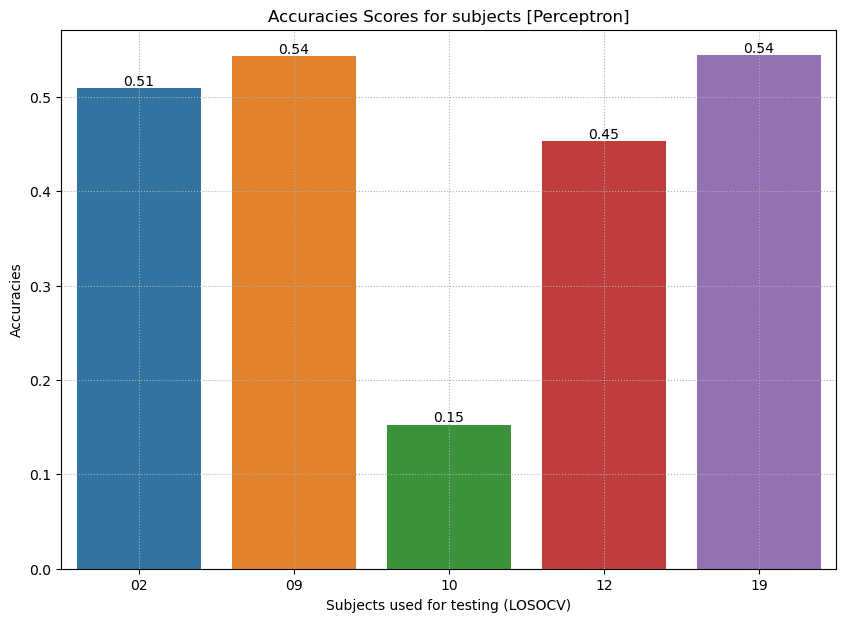

In [23]:
# Plotting individual metrics
plot_single_metric(classifier, results, 'accuracies')

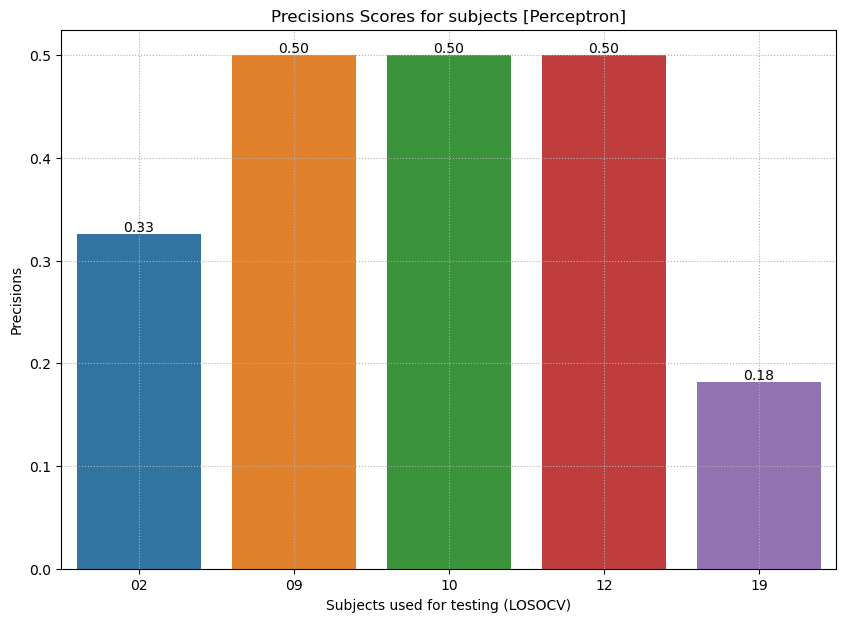

In [24]:
plot_single_metric(classifier, results, 'precisions')

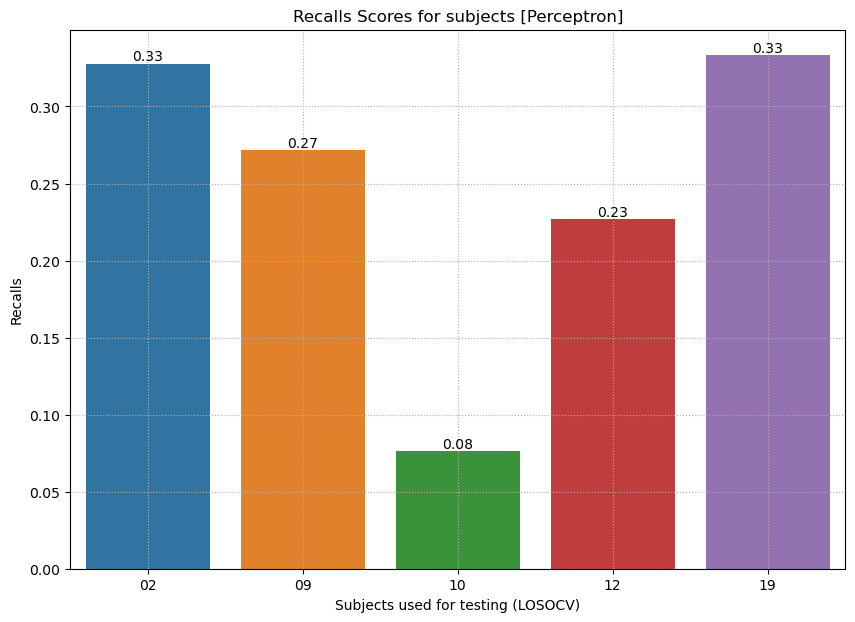

In [25]:
plot_single_metric(classifier, results, 'recalls')

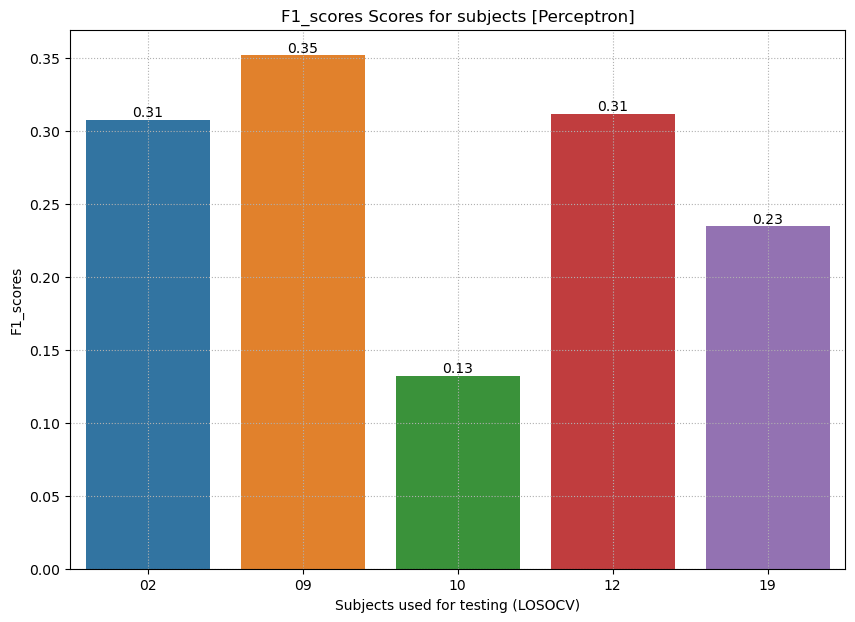

In [26]:
plot_single_metric(classifier, results, 'f1_scores')

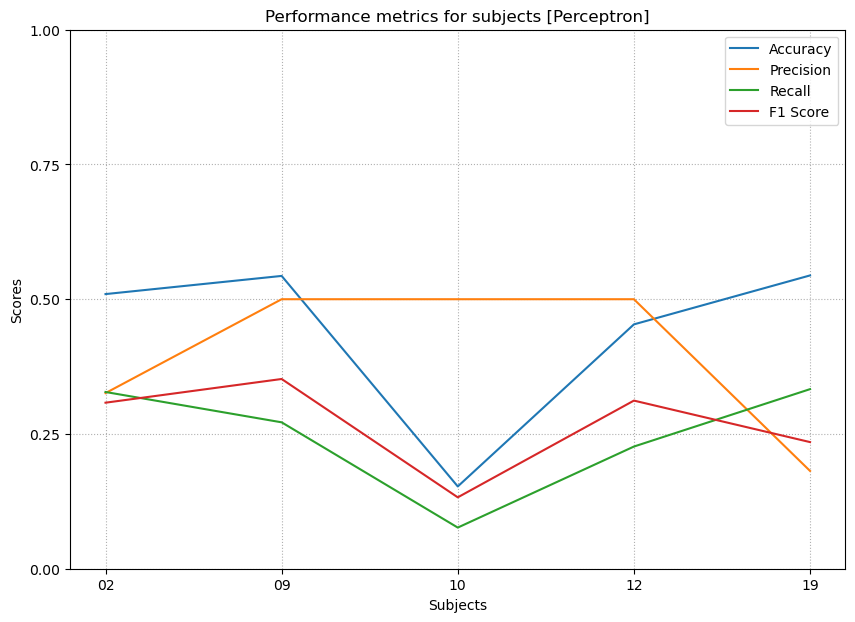

In [27]:
# Plotting all metrics in a single chart
plot_all_metrics(classifier, results, num_ticks=5)

## Inference on new subjects

In [28]:
def max_voting(predictions_list):
    # Convert the list of predictions into a numpy array for easier manipulation
    predictions_array = np.array(predictions_list)

    # Transpose the array to work with predictions of each sample across models
    transposed_array = np.transpose(predictions_array)

    # Create an empty list to store the final predictions
    final_predictions = []

    # Iterate through each sample's predictions
    for sample_predictions in transposed_array:
        # Calculate the mode (most frequent value) of predictions for each sample
        mode_prediction = np.argmax(np.bincount(sample_predictions.astype(int)))

        # Append the mode prediction to the final predictions list
        final_predictions.append(mode_prediction)

    return final_predictions

In [29]:
# Function to load model
def get_voting_ensemble(folder, model_names):
    
    models = []
    logger.info(f"Loading fitted models from {folder}. Fitted Models: {model_names}")
    for name in model_names:
        model = om.load_object(f"models/{folder}", f"{name}.pt")
        models.append(model)
        #models.append((f"{classifier}_{name}", model))
    
    #ensemble = VotingClassifier(estimators=models, voting='soft')
    
    return models #ensemble

# Function to run inference on subjects
def run_inference(ensemble, folder, filenames, features = [], normalize = True, sampling=False):
    metrics = {
    key: []
    for key in [
        Metrics.Accuracy.value,
        Metrics.Precision.value,
        Metrics.Recall.value,
        Metrics.F1.value,
        Metrics.Sample.value,
    ]
    }

    # Dictionary to store weighted avergae metrics
    weighted_avg_metrics = {}
    logger.info(f"Taking features: {features}")
    #Loop over csv files of each subject
    for file in filenames:
        #Load data
        x_test, y_test = dfm.load_data(file, data_folder, normalize, norm_method,features,sampling=False)
        
        y_preds = []
        
        # Evaluate the classifier on the current chunk
        for model in ensemble:
            y_pred = model.predict(x_test)
            y_preds.append(y_pred)
        
        # Get best predictions using max vote
        y_final = max_voting(y_preds)
        
        # Get evaluation metrics
        result = evaluate_metrics(y_test,y_pred)
        
        # Concat values
        metrics.update(result)
    
    
    # Calculate total number of samples
    total_samples = sum(metrics[Metrics.Sample.value])
    
    # Calculate the weighted average metrics
    
    for key, values in metrics.items():
        if key != Metrics.Sample.value:
            weighted_key_sum =  sum(val * count for val, count in zip(values, metrics[Metrics.Sample.value]))
            weighted_avg_metrics[key]= weighted_key_sum / total_samples
    
    logger.info("***"*20)
    logger.info(f"Inference Results:")
    for k, v in weighted_avg_metrics.items():
        logger.info(f"{k}:{v:.2f}")
            
    return weighted_avg_metrics

In [30]:
#folder = '2023-08-03_11-10-20'
ensemble = get_voting_ensemble(folder, subjects)

2023-08-22 00:09:05 - INFO - Loading fitted models from 2023-08-21_23-25-59. Fitted Models: ['02', '09', '10', '12', '19']


In [31]:
inference_subjects = ['07', '27', '15', '24', '22']

In [32]:
infer_result = []

for test_subject in inference_subjects:
    logger.info("###"*10)
    logger.info(f"Running ensemble on test subject:{test_subject}")
    filenames = grouped_csv_files[test_subject]
    output = run_inference(ensemble, "OCDetect_Export", filenames, features = features, normalize = True)
    infer_result.append({test_subject:output})
    logger.info(f"Completed ensemble on test subject: {test_subject}")

2023-08-22 00:09:05 - INFO - ##############################
2023-08-22 00:09:05 - INFO - Running ensemble on test subject:07
2023-08-22 00:09:05 - INFO - Taking features: ['acc x', 'acc y', 'acc z', 'gyro x', 'gyro y', 'gyro z']
2023-08-22 00:09:05 - INFO - Loading CSV File: OCDetect_07_recording_00_36b52ec7-be69-44fe-82d6-d7165abfdac1.csv from OCDetect_Export.
2023-08-22 00:09:05 - INFO - ---------------
2023-08-22 00:09:05 - INFO - Loading CSV File: OCDetect_07_recording_01_ba42ec72-01cd-4969-bcba-226869a3288e.csv from OCDetect_Export.
2023-08-22 00:09:05 - INFO - ---------------
2023-08-22 00:09:05 - INFO - Loading CSV File: OCDetect_07_recording_02_9c1649e7-f686-4d1b-9169-6ff4566b0726.csv from OCDetect_Export.
2023-08-22 00:09:05 - INFO - ---------------
2023-08-22 00:09:05 - INFO - Loading CSV File: OCDetect_07_recording_03_8e5a64aa-78f3-4992-a6db-a54918de201f.csv from OCDetect_Export.
2023-08-22 00:09:05 - INFO - ---------------
2023-08-22 00:09:05 - INFO - Loading CSV File: OCDe

2023-08-22 00:09:44 - INFO - ---------------
2023-08-22 00:09:44 - INFO - Loading CSV File: OCDetect_07_recording_20_c8b405dc-d94a-48e4-a92c-9447086aabb8.csv from OCDetect_Export.
2023-08-22 00:09:49 - INFO - Original distribution: Counter({0: 969578, 1: 3802})
2023-08-22 00:09:49 - INFO - Class distribution after oversampling: Counter({0: 969578, 1: 12356})
2023-08-22 00:09:49 - INFO - Class distribution after RandomUnderSampler: Counter({0: 323192, 1: 12356})
2023-08-22 00:09:50 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 12356, 0: 7192})
2023-08-22 00:09:50 - INFO - ---------------
2023-08-22 00:09:50 - INFO - ************************************************************
2023-08-22 00:09:50 - INFO - Inference Results:
2023-08-22 00:09:50 - INFO - accuracy:0.37
2023-08-22 00:09:50 - INFO - precision:0.12
2023-08-22 00:09:50 - INFO - recall:0.33
2023-08-22 00:09:50 - INFO - f1:0.18
2023-08-22 00:09:50 - INFO - Completed ensemble on test subject: 07
2023-08-22 

2023-08-22 00:11:03 - INFO - ---------------
2023-08-22 00:11:03 - INFO - Loading CSV File: OCDetect_15_recording_02_2cdf6e74-4377-40a1-8ff0-b9ca3a73df38.csv from OCDetect_Export.
2023-08-22 00:11:05 - INFO - Original distribution: Counter({0: 1163133, 1: 7604, 2: 1901})
2023-08-22 00:11:05 - INFO - Class distribution after oversampling: Counter({0: 1163133, 1: 9505, 2: 9505})
2023-08-22 00:11:06 - INFO - Class distribution after RandomUnderSampler: Counter({0: 387711, 1: 9505, 2: 9505})
2023-08-22 00:11:07 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 9505, 1: 9505, 2: 9505})
2023-08-22 00:11:07 - INFO - ---------------
2023-08-22 00:11:07 - INFO - Loading CSV File: OCDetect_15_recording_03_e39f364d-d3d1-4396-a652-8d856a70bda1.csv from OCDetect_Export.
2023-08-22 00:11:09 - INFO - ---------------
2023-08-22 00:11:09 - INFO - Loading CSV File: OCDetect_15_recording_04_578d2f52-6407-4e73-846c-a756b95dfbc5.csv from OCDetect_Export.
2023-08-22 00:11:13 - INFO - Ori

2023-08-22 00:12:05 - INFO - Class distribution after RandomUnderSampler: Counter({0: 76974, 1: 7936})
2023-08-22 00:12:06 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 7936, 0: 1390})
2023-08-22 00:12:06 - INFO - ---------------
2023-08-22 00:12:06 - INFO - Loading CSV File: OCDetect_15_recording_17_ecbf1d93-1e6e-436b-9143-1d2c29300c25.csv from OCDetect_Export.
2023-08-22 00:12:06 - INFO - Original distribution: Counter({0: 114351, 1: 1460})
2023-08-22 00:12:07 - INFO - Class distribution after oversampling: Counter({0: 114351, 1: 4745})
2023-08-22 00:12:07 - INFO - Class distribution after RandomUnderSampler: Counter({0: 38117, 1: 4745})
2023-08-22 00:12:07 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 4745, 0: 1377})
2023-08-22 00:12:07 - INFO - ---------------
2023-08-22 00:12:07 - INFO - Loading CSV File: OCDetect_15_recording_18_c074e940-abb4-40df-83b7-84d4e8b14bdf.csv from OCDetect_Export.
2023-08-22 00:12:07 - INFO - -------------

2023-08-22 00:13:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({0: 4078, 1: 4078, 2: 4078})
2023-08-22 00:13:00 - INFO - ---------------
2023-08-22 00:13:00 - INFO - Loading CSV File: OCDetect_22_recording_05_bd7c18a9-cd01-4d92-a7ea-69fa7cd7439d.csv from OCDetect_Export.
2023-08-22 00:13:00 - INFO - Original distribution: Counter({1: 939, 0: 909})
2023-08-22 00:13:00 - INFO - Class distribution after oversampling: Counter({0: 2954, 1: 939})
2023-08-22 00:13:00 - INFO - Class distribution after RandomUnderSampler: Counter({0: 984, 1: 939})
2023-08-22 00:13:00 - INFO - Class distribution after NearMiss UnderSampling: Counter({1: 939, 0: 243})
2023-08-22 00:13:00 - INFO - ---------------
2023-08-22 00:13:00 - INFO - Loading CSV File: OCDetect_22_recording_06_05881326-aab1-440e-a45b-8900a053047c.csv from OCDetect_Export.
2023-08-22 00:13:02 - INFO - Original distribution: Counter({0: 335240, 2: 8083, 1: 1901})
2023-08-22 00:13:02 - INFO - Class distribution after ove

2023-08-22 00:14:08 - INFO - ************************************************************
2023-08-22 00:14:08 - INFO - Inference Results:
2023-08-22 00:14:08 - INFO - accuracy:0.33
2023-08-22 00:14:08 - INFO - precision:0.11
2023-08-22 00:14:08 - INFO - recall:0.33
2023-08-22 00:14:08 - INFO - f1:0.17
2023-08-22 00:14:08 - INFO - Completed ensemble on test subject: 22


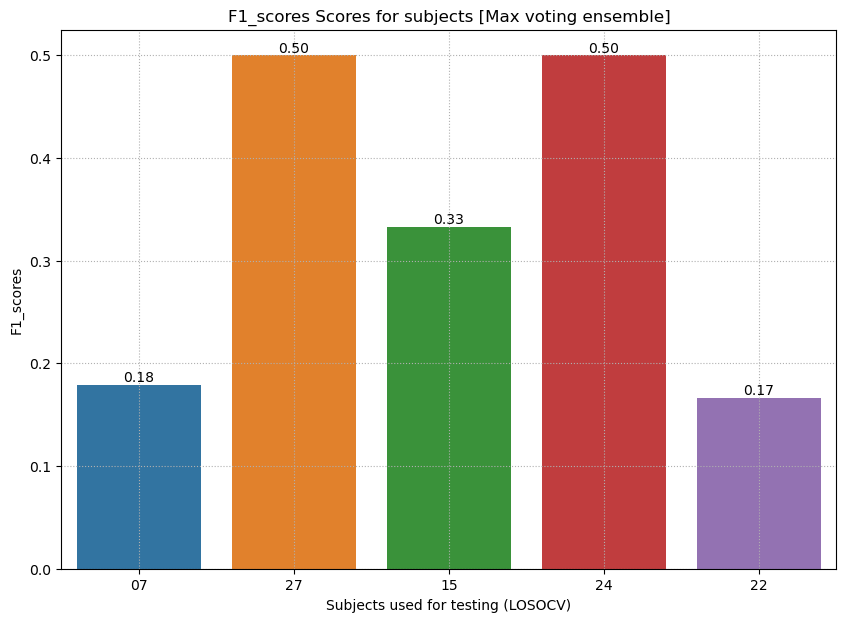

In [33]:
plot_single_metric("Max Voting Ensemble", infer_result, "f1_scores")

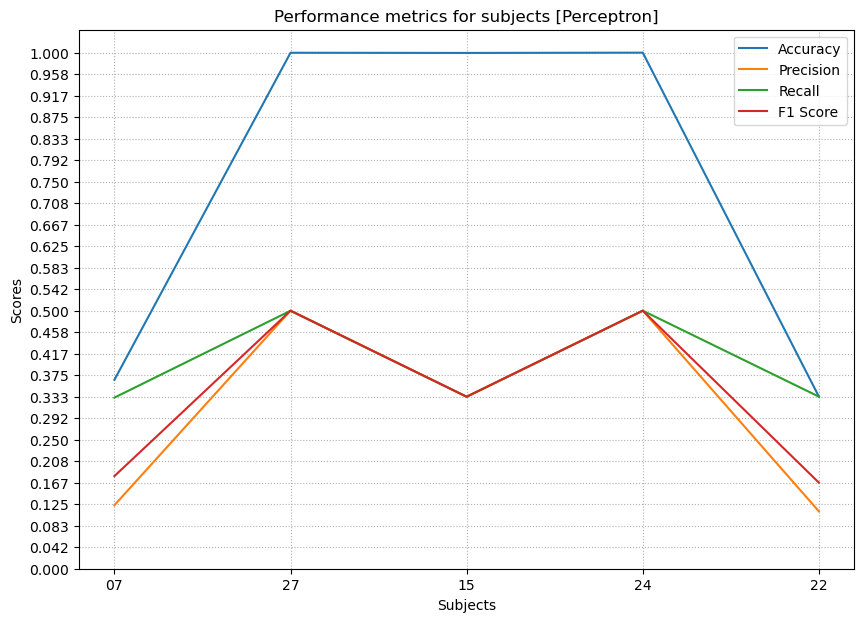

In [34]:
# Plotting all metrics in a single chart
plot_all_metrics(classifier, infer_result, num_ticks=25)